**Rozdział 2. Nasz pierwszy projekt uczenia maszynowego**

*Witaj w korporacji Inteligentne Nieruchomości! Twoim zadaniem jest przewidywanie mediany wartości cen median w kalifornijskich dystryktach mając określoną liczbę cech charakteryzujących te dystrykty.*

*Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 2.*

**Uwaga**: Z powodu losowości występujące w wielu algorytmach uczących mogą pojawiać się niewielkie różnice pomiędzy wynikami umieszczonymi w książce a generowanymi przez notatniki Jupyter: starałem się, aby rezultaty były w maksymalnym stopniu powatrzalne, nie mogę jednak zagwarantować, że będą one identycznej na każdej dostępnej platformie. Ponadto pewne struktury danych (np. słowniki) nie zachowują kolejności elementów. Poprawiłem także kilka niewielkich błędów (zawierające je komórki zostały opatrzone odpowiednimi uwagami), które prowadziły do odmiennych wyników, modyfikacje te jednak nie wpłynęły na założenia opisywane w książce.

# Konfiguracja

Upewnijmy się najpierw, że notatnik ten będzie działał w środowiskach Python 2 i 3, importujmy kilka powszechnie stosowanych modułów, upewnijmy się, że moduł MatplotLib będzie prawidłowo tworzył wykresy, a także przygotujmy funkcję zapisującą rysunki:

In [1]:
# Obsługa środowisk Python 2 i Python 3
from __future__ import division, print_function, unicode_literals

# Importowanie popularnych modułów
import numpy as np
import os

# W celu zachowania powtarzalności wyników w kolejnych przebiegach
np.random.seed(42)

# Generowanie ładnych wykresów
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Lokacja, w której będą zapisywane rysunki
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "pierwszy_projekt"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Pozyskanie danych

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("zestawy danych", "mieszkania")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [25]:
housing = load_housing_data()
housing.rename(columns={"longitude": "Dł. geograficzna", "latitude": "Szer. geograficzna", "housing_median_age": "Mediana wieku mieszkań",
                        "total_rooms": "Całk. liczba pokoi", "total_bedrooms": "Całk. liczba sypialni", "population": "Populacja",
                        "households": "Rodziny", "median_income": "Mediana dochodów", "median_house_value": "Mediana cen mieszkań",
                        "ocean_proximity": "Odległość do oceanu"}, inplace=True)
housing.head()

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Mediana cen mieszkań,Odległość do oceanu
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [26]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
Dł. geograficzna          20640 non-null float64
Szer. geograficzna        20640 non-null float64
Mediana wieku mieszkań    20640 non-null float64
Całk. liczba pokoi        20640 non-null float64
Całk. liczba sypialni     20433 non-null float64
Populacja                 20640 non-null float64
Rodziny                   20640 non-null float64
Mediana dochodów          20640 non-null float64
Mediana cen mieszkań      20640 non-null float64
Odległość do oceanu       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [27]:
housing["Odległość do oceanu"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: Odległość do oceanu, dtype: int64

In [28]:
housing.describe()

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Mediana cen mieszkań
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Zapisywanie rysunku wykresy_histogramu_atrybutów


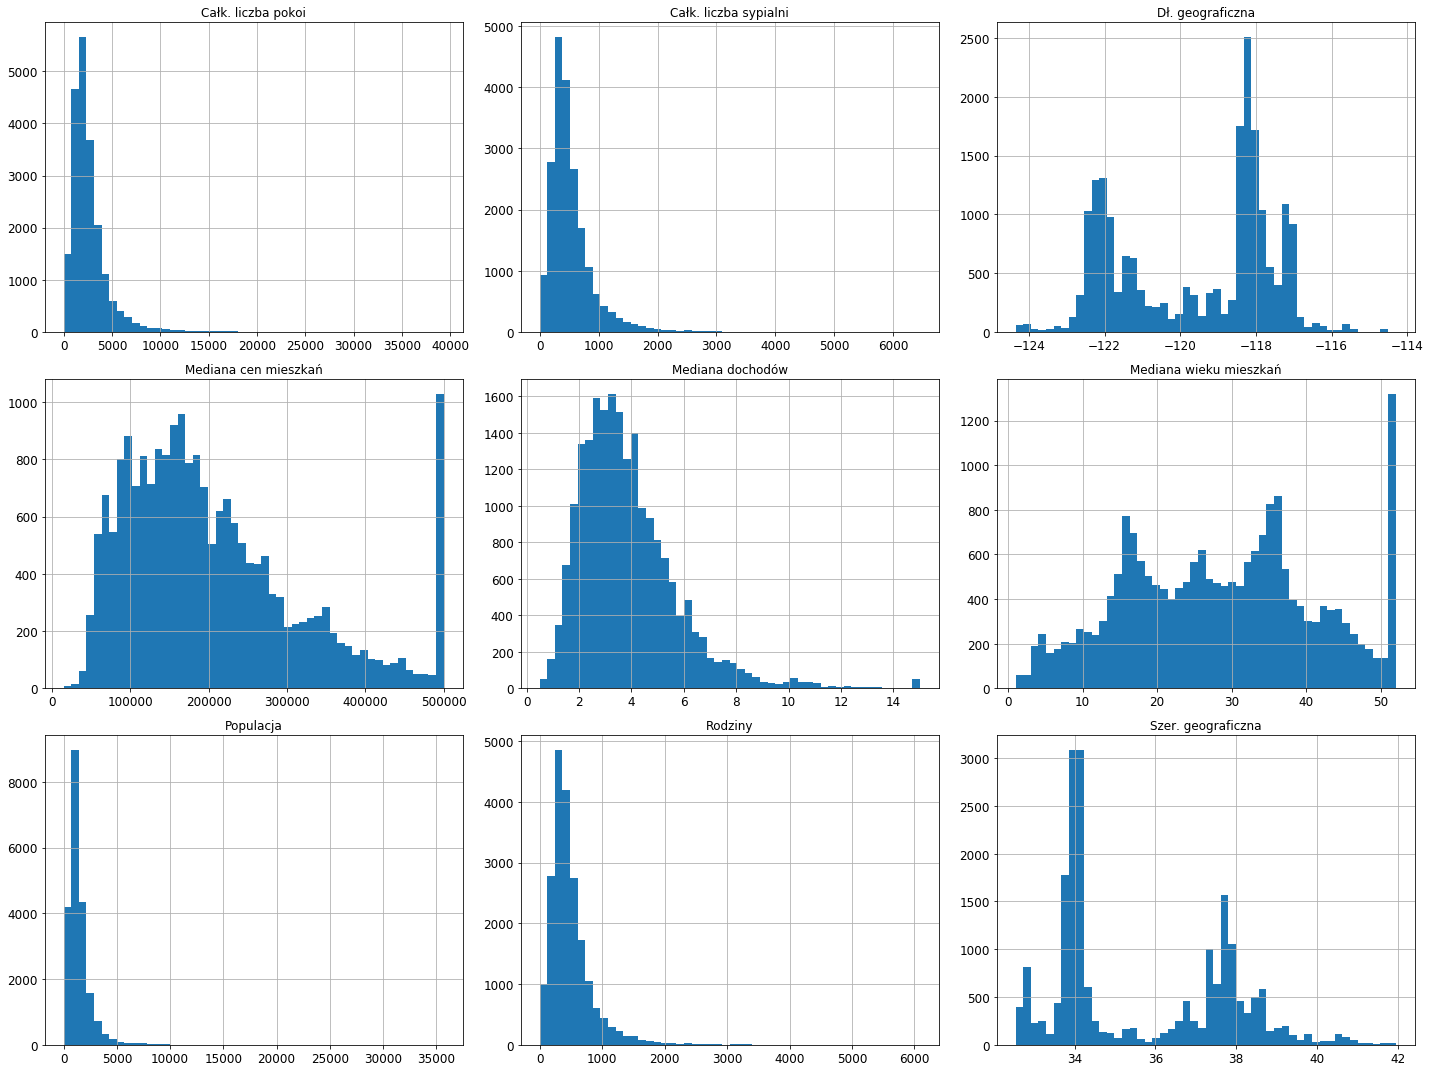

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("wykresy_histogramu_atrybutów")
plt.show()

In [30]:
# w celu zapewnienia powtarzalności wyników przy każdym przebiegu notatnika
np.random.seed(42)

In [31]:
import numpy as np

# Jedynie w celach ilustracyjnych. Moduł Sklearn zawiera funkcję train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [32]:
train_set, test_set = split_train_test(housing, 0.2)
print("Uczące:", len(train_set), ", testowe:", len(test_set))

Uczące: 16512 , testowe: 4128


In [33]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [34]:
# Ta wersja obsługuje środowiska Python 2 i 3, a nie tylko Python 3.
def test_set_check(identifier, test_ratio, hash):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [39]:
housing_with_id = housing.reset_index()   # Dodaje kolumnę `index`
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
housing_with_id.rename(columns={"index": "Indeks"})

,Indeks,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Mediana cen mieszkań,Odległość do oceanu
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [41]:
housing_with_id["id"] = housing["Dł. geograficzna"] * 1000 + housing["Szer. geograficzna"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
housing_with_id.rename(columns={"index": "Indeks", "id": "Identyfikator"})

,Indeks,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Mediana cen mieszkań,Odległość do oceanu,Identyfikator
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,-122212.15
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY,-122212.16
7,7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY,-122212.16
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
9,9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY,-122212.16


In [44]:
test_set.head()
test_set.rename(columns={"index": "Indeks", "id": "Identyfikator"})

,Indeks,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Mediana cen mieszkań,Odległość do oceanu,Identyfikator
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16
14,14,-122.26,37.85,52.0,2643.0,626.0,1212.0,620.0,1.9167,159200.0,NEAR BAY,-122222.15
15,15,-122.26,37.85,50.0,1120.0,283.0,697.0,264.0,2.1250,140000.0,NEAR BAY,-122222.15
18,18,-122.26,37.84,50.0,2239.0,455.0,990.0,419.0,1.9911,158700.0,NEAR BAY,-122222.16
38,38,-122.26,37.83,52.0,1470.0,330.0,689.0,309.0,3.4800,191400.0,NEAR BAY,-122222.17
39,39,-122.26,37.83,52.0,2432.0,715.0,1377.0,696.0,2.5898,176000.0,NEAR BAY,-122222.17


In [45]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [46]:
test_set.head()

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Mediana cen mieszkań,Odległość do oceanu
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


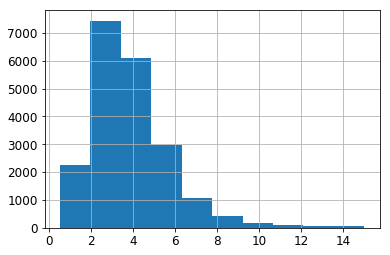

In [47]:
housing["Mediana dochodów"].hist()

In [48]:
# Dzieli wartość przez 1,5 w celu ograniczenia liczby kategorii dochodów
housing["kat_dochodów"] = np.ceil(housing["Mediana dochodów"] / 1.5)
# Wartości przekraczające wartość 5 zostają przyporządkowane do klasy 5
housing["kat_dochodów"].where(housing["kat_dochodów"] < 5, 5.0, inplace=True)

In [49]:
housing["kat_dochodów"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: kat_dochodów, dtype: int64

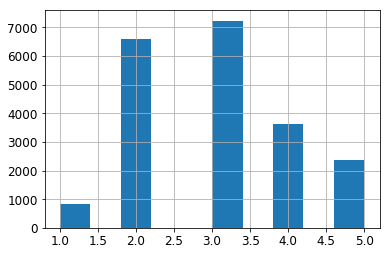

In [50]:
housing["kat_dochodów"].hist()

In [51]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["kat_dochodów"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [52]:
strat_test_set["kat_dochodów"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: kat_dochodów, dtype: float64

In [53]:
housing["kat_dochodów"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: kat_dochodów, dtype: float64

In [54]:
def income_cat_proportions(data):
    return data["kat_dochodów"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Łącznie": income_cat_proportions(housing),
    "L. warstwowe": income_cat_proportions(strat_test_set),
    "Losowe": income_cat_proportions(test_set),
}).sort_index()
compare_props["Błąd - losowe (%)"] = 100 * compare_props["Losowe"] / compare_props["Łącznie"] - 100
compare_props["Błąd - l. warstwowe (%)"] = 100 * compare_props["L. warstwowe"] / compare_props["Łącznie"] - 100

In [55]:
compare_props

,L. warstwowe,Losowe,Łącznie,Błąd - losowe (%),Błąd - l. warstwowe (%)
1.0,0.039729,0.040213,0.039826,0.973236,-0.243309
2.0,0.318798,0.324370,0.318847,1.732260,-0.015195
3.0,0.350533,0.358527,0.350581,2.266446,-0.013820
4.0,0.176357,0.167393,0.176308,-5.056334,0.027480
5.0,0.114583,0.109496,0.114438,-4.318374,0.127011


In [56]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("kat_dochodów", axis=1, inplace=True)

# Odkrywanie i wizualizowanie danych w celu zdobywania nowych informacji

In [57]:
housing = strat_train_set.copy()

Zapisywanie rysunku zły_wykres_wizualizacji


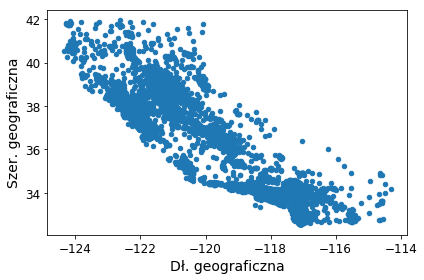

In [58]:
housing.plot(kind="scatter", x="Dł. geograficzna", y="Szer. geograficzna")
save_fig("zły_wykres_wizualizacji")

Zapisywanie rysunku lepszy_wykres_wizualizacji


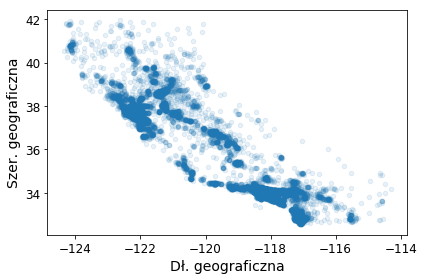

In [59]:
housing.plot(kind="scatter", x="Dł. geograficzna", y="Szer. geograficzna", alpha=0.1)
save_fig("lepszy_wykres_wizualizacji")

Argument `sharex=False` usuwa błąd wyświetlania (nie były wyświetlane wartości osi x i legenda). Jest to tymczasowe rozwiązanie (patrz https://github.com/pandas-dev/pandas/issues/10611). Podziękowania dla Wilmera Arellano za wskazanie tego błędu.

Zapisywanie rysunku wykres_punktowy_cen_mieszkań


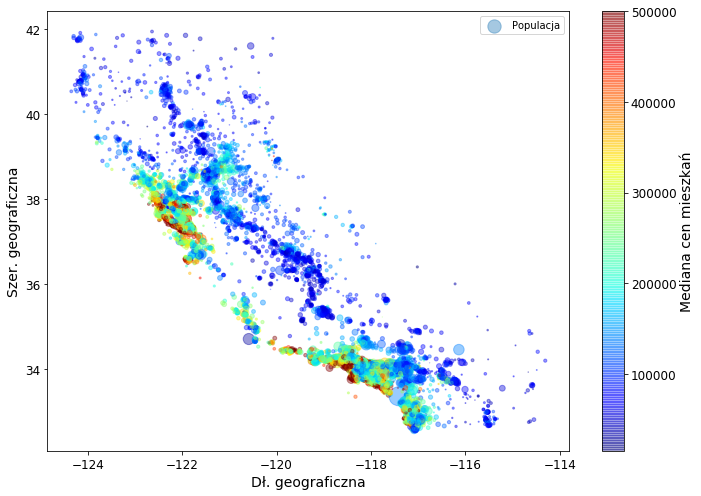

In [60]:
housing.plot(kind="scatter", x="Dł. geograficzna", y="Szer. geograficzna", alpha=0.4,
    s=housing["Populacja"]/100, label="Populacja", figsize=(10,7),
    c="Mediana cen mieszkań", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("wykres_punktowy_cen_mieszkań")

Zapisywanie rysunku wykres_punktowy_cen_mieszkań_z_mapą_Kalifornii


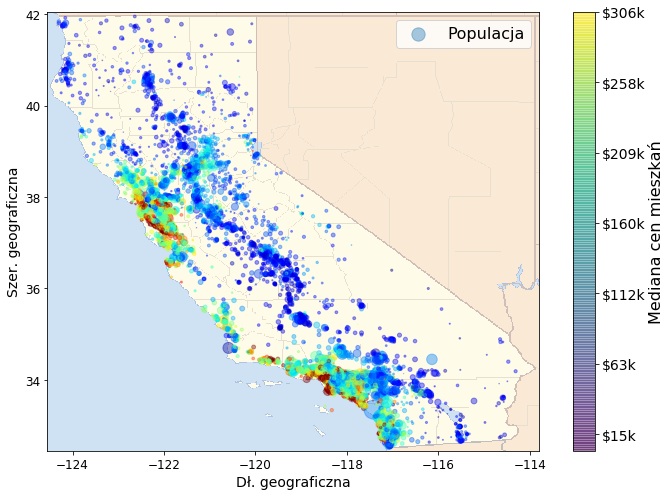

In [62]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/rysunki/pierwszy_projekt/Kalifornia.png')
ax = housing.plot(kind="scatter", x="Dł. geograficzna", y="Szer. geograficzna", figsize=(10,7),
                       s=housing['Populacja']/100, label="Populacja",
                       c="Mediana cen mieszkań", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Szer. geograficzna", fontsize=14)
plt.xlabel("Dł. geograficzna", fontsize=14)

prices = housing["Mediana cen mieszkań"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Mediana cen mieszkań', fontsize=16)

plt.legend(fontsize=16)
save_fig("wykres_punktowy_cen_mieszkań_z_mapą_Kalifornii")
plt.show()

In [63]:
corr_matrix = housing.corr()

In [64]:
corr_matrix["Mediana cen mieszkań"].sort_values(ascending=False)

Mediana cen mieszkań      1.000000
Mediana dochodów          0.687160
Całk. liczba pokoi        0.135097
Mediana wieku mieszkań    0.114110
Rodziny                   0.064506
Całk. liczba sypialni     0.047689
Populacja                -0.026920
Dł. geograficzna         -0.047432
Szer. geograficzna       -0.142724
Name: Mediana cen mieszkań, dtype: float64

Zapisywanie rysunku wykres_macierzy_rozproszonej


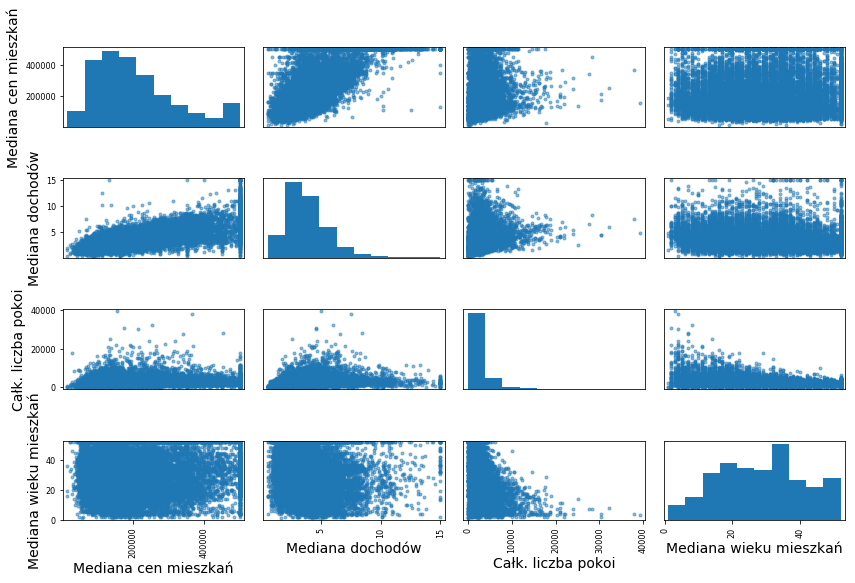

In [66]:
#from pandas.tools.plotting import scatter_matrix # Dla starszych wersji środowiska Pandas
from pandas.plotting import scatter_matrix

attributes = ["Mediana cen mieszkań", "Mediana dochodów", "Całk. liczba pokoi",
              "Mediana wieku mieszkań"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("wykres_macierzy_rozproszonej")

Zapisywanie rysunku wykres_punktowy_porównania_dochodów_do_wartości_mieszkań


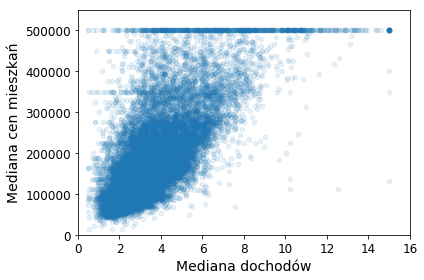

In [68]:
housing.plot(kind="scatter", x="Mediana dochodów", y="Mediana cen mieszkań",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("wykres_punktowy_porównania_dochodów_do_wartości_mieszkań")

In [69]:
housing["Pokoje_na_rodzinę"] = housing["Całk. liczba pokoi"]/housing["Rodziny"]
housing["Sypialnie_na_pokoje"] = housing["Całk. liczba sypialni"]/housing["Całk. liczba pokoi"]
housing["Populacja_na_rodzinę"]=housing["Populacja"]/housing["Rodziny"]

Uwaga: w powyższej komórce znajdował się błąd, dokładniej w definicji atrybutu `Pokoje_na_rodzinę`. Z tego właśnie powodu występują pewne różnice pomiędzy obliczoną tu korelacją a wartością podaną w książce (błąd ten został poprawiony w jej najnowszym wydaniu).

In [70]:
corr_matrix = housing.corr()
corr_matrix["Mediana cen mieszkań"].sort_values(ascending=False)

Mediana cen mieszkań      1.000000
Mediana dochodów          0.687160
Pokoje_na_rodzinę         0.146285
Całk. liczba pokoi        0.135097
Mediana wieku mieszkań    0.114110
Rodziny                   0.064506
Całk. liczba sypialni     0.047689
Populacja_na_rodzinę     -0.021985
Populacja                -0.026920
Dł. geograficzna         -0.047432
Szer. geograficzna       -0.142724
Sypialnie_na_pokoje      -0.259984
Name: Mediana cen mieszkań, dtype: float64

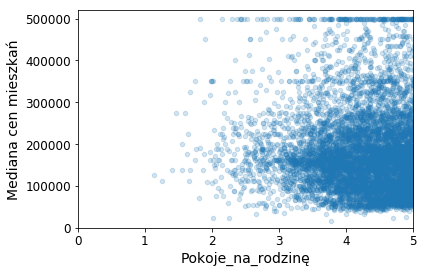

In [71]:
housing.plot(kind="scatter", x="Pokoje_na_rodzinę", y="Mediana cen mieszkań",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [72]:
housing.describe()

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Mediana cen mieszkań,Pokoje_na_rodzinę,Sypialnie_na_pokoje,Populacja_na_rodzinę
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Przygotowanie danych pod algorytmy uczenia maszynowego

In [73]:
housing = strat_train_set.drop("Mediana cen mieszkań", axis=1) # usuwa etykiety w zbiorze uczącym
housing_labels = strat_train_set["Mediana cen mieszkań"].copy()

In [74]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Odległość do oceanu
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [75]:
sample_incomplete_rows.dropna(subset=["Całk. liczba sypialni"])    # pierwsza możliwość

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Odległość do oceanu


In [76]:
sample_incomplete_rows.drop("Całk. liczba sypialni", axis=1)       # druga możliwość

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Populacja,Rodziny,Mediana dochodów,Odległość do oceanu
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [77]:
median = housing["Całk. liczba sypialni"].median()
sample_incomplete_rows["Całk. liczba sypialni"].fillna(median, inplace=True) # trzecia możliwość
sample_incomplete_rows

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Odległość do oceanu
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [78]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

Usuwamy atrybut tekstowy, ponieważ mediana może być obliczana wyłącznie wobec atrybutów numerycznych:

In [79]:
housing_num = housing.drop('Odległość do oceanu', axis=1)
# ewentualnie: housing_num = housing.select_dtypes(include=[np.number])

In [80]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [81]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

Sprawdzamy, czy uzyskany wynik jest taki sam, jak ręczne obliczenie mediany każdego atrybutu:

In [82]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

Przekształcamy zbiór uczący:

In [83]:
X = imputer.transform(housing_num)

In [84]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [85]:
housing_tr.loc[sample_incomplete_rows.index.values]

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [86]:
imputer.strategy

'median'

In [87]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


Przetwórzmy wstępnie wartości cechy kategorialnej `Odległość do oceanu`:

In [88]:
housing_cat = housing['Odległość do oceanu']
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: Odległość do oceanu, dtype: object

Możemy wykorzystać metodę `factorize()` modułu Pandas do przekształcenia tej cechy kategorialnej zawierającej ciągi znaków w cechę kategorialną zawierającą liczby stałoprzecinkowe, które są łatwiej przetwarzane przez algorytmy uczenia maszynowego:

In [89]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0], dtype=int64)

In [90]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

**Ostrzeżenie**: we wcześniejszych wersjach książki używałem klasy `LabelEncoder` zamiast metody `factorize()`. Było to niewłaściwe rozwiązanie: w istocie, jak sama nazwa wskazuje, klasa `LabelEncoder` została zaprojektowana pod względem etykiet, nie cech wejściowych. Napisany przeze mnie kod działał, ponieważ zajmowaliśmy się pojedynczą kategorialną cechą wejściową, gdybyśmy jednak przekazali tej klasie więcej kategorialnych cech wejściowych, kod by się "rozsypał".

Za pomocą klasy `OneHotEncoder` możemy przekształcić każdą wartość kategorialną do postaci wektora "gorącojedynkowego":

In [91]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Klasa `OneHotEncoder` zwraca domyślnie macierz rzadką, ale w razie potrzeby możemy ją przekształcić do postaci gęstej: 

In [92]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

**Ostrzeżenie**: we wcześniejszych wersjach książki stosowałem tutaj klasę `LabelBinarizer` i to również było nieprawidłowe zachowanie: podobnie jak w przypadku klasy `LabelEncoder` klasa `LabelBinarizer` została zaprojektowana w celu wstępnego przetwarzania etykiet, a nie cech wejściowych. Lepszym rozwiązaniem jest używanie szykowanej klasy `CategoricalEncoder` modułu Scikit-Learn: zostanie ona wkrótce dołączona do modułu Scikit-Learn, tymczasem zaś możesz skorzystać z poniższego kodu (skopiowanego z [prośby #9151](https://github.com/scikit-learn/scikit-learn/pull/9151)).

In [93]:
# Definicja klasy CategoricalEncoder, skopiowana z prośby PR #9151.
# Uruchom tę komórkę nie próbując rozumieć jej zawartości (na razie).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Koduje cechy kategorialne w postaci macierzy numerycznej.
    Danymi wejściowymi dostarczanymi do tego transformatora powinna być macierz
    zawierająca liczby stałoprzecinkowe lub ciągi znaków, symbolizujące
    wartości przechowywane przez cechy kategorialne (dyskretne).
    Możemy kodować cechy za pomocą schematu "gorącojedynkowego" (jeden-z-K)
    (``encoding='onehot'``, domyślne rozwiązanie) lub przekształcać je do postaci
    liczb porządkowych (``encoding='ordinal'``).
    Tego typu kodowanie jest wymagane podczas dostarczania danych kategorialnych do wielu
    etymatorów modułu Scikit-Learn, mianowicie w modelach liniowych i maszynach
    SVM wykorzystujących standardowe jądra. Więcej informacji znajdziesz w:
    :ref:`User Guide <preprocessing_categorical_features>`.
    Parametry
    ----------
    encoding : ciąg znaków, 'onehot', 'onehot-dense' lub 'ordinal'
        Rodzaj stosowanego kodowania (domyślna wartość to 'onehot'):
        - 'onehot': koduje cechy za pomocą schematu "gorącojedynkowego" (jeden-z-K,
           bywa również nazywany kodowaniem 'sztucznym'). Zostaje utworzona kolumna
           binarna dla każdej kategorii, a zwracana jest macierz rzadka.
        - 'onehot-dense': to samo, co wartość 'onehot', ale zwraca macierz gęstą zamiast rzadkiej.
        - 'ordinal': koduje cechy w postaci liczb porządkowych. Uzyskujemy w ten sposób 
          pojedynczą kolumną zawierającą liczby stałoprzecinkowe (od 0 do n_kategorii - 1) 
          dla każdej cechy.
    categories : 'auto' lub lista list/tablic wartości.
        Kategorie (niepowtarzalne wartości) na każdą cechę:
        - 'auto' : Automatycznie określa kategorie za pomocą danych uczących. 
        - lista : ``categories[i]`` przechowuje kategorie oczekiwane w i-tej kolumnie.
          Przekazane kategorie zostają posortowanie przed zakodowaniem danych
          (użyte kategorie można przejrzeć w atrybucie ``categories_``).
    dtype : typ liczby, domyślnie np.float64
        Wymagany typ wartości wyjściowej.
    handle_unknown : 'error' (domyślnie) lub 'ignore'
        Za jego pomocą określamy, czy w przypadku obecności nieznanej cechy w czasie
        wykonywania transformacji ma być wyświetlany komunikat o błędzie (wartość
        domyślna) lub czy ma zostać zignorowana. Po wybraniu wartości 'ignore' 
        i natrafieniu na nieznaną kategorię w trakcie przekształceń, wygenerowane
        kolumny "gorącojedynkowe" dla tej cechy będą wypełnione zerami. 
        Ignorowanie nieznanych kategorii nie jest obsługiwane w parametrze
        ``encoding='ordinal'``.
    Atrybuty
    ----------
    categories_ : lista tablic
        Kategorie każdej cechy określone podczas uczenia. W przypadku ręcznego 
        wyznaczania kategorii znajdziemy tu listę posortowanych kategorii
        (w kolejności odpowiadającej wynikowi operacji 'transform').
    Przykłady
    --------
    Mając zbiór danych składający się z trzech cech i dwóch próbek pozwalamy koderowi
    znaleźć maksymalną wartość każdej cechy i przekształcić dane do postaci
    binarnego kodowania "gorącojedynkowego".
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    Powiązane materiały
    --------
    sklearn.preprocessing.OneHotEncoder : przeprowadzana kodowanie "gorącojedynkowe"
      stałoprzecinkowych cech porządkowych. Klasa ``OneHotEncoder zakłada``, że cechy wejściowe
      przechowują wartości w zakresie ``[0, max(cecha)]`` zamiast korzystać z
      niepowtarzalnych wartości.
    sklearn.feature_extraction.DictVectorizer : przeprowadzana kodowanie "gorącojedynkowe"
      elementów słowanika (a także cech przechowujących ciągi znaków).
    sklearn.feature_extraction.FeatureHasher : przeprowadzana przybliżone kodowanie "gorącojedynkowe"
      elementów słownika lub ciągów znaków.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Dopasowuje klasę CategoricalEncoder do danych wejściowych X.
        Parametry
        ----------
        X : tablicopodobny, postać [n_próbek, n_cech]
            Dane służące do określania kategorii każdej cechy.
        Zwraca
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("Należy wybrać jedno z następujących kodowań: 'onehot', 'onehot-dense' "
                        "lub 'ordinal', wybrano %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("Należy wybrać jedną z następujących wartości parametru handle_unknown: 'error' lub "
                        "'ignore', wybrano %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("Wartość handle_unknown='ignore' nie jest obsługiwana przez parametr"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Znaleziono nieznane kategorie {0} w kolumnie {1}"
                               " podczas dopasowywania".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Przekształca X za pomocą kodowania "gorącojedynkowego".
        Parametry
        ----------
        X : tablicopodobny, postać [n_próbek, n_cech]
            Kodowane dane.
        Zwraca
        -------
        X_out : macierz rzadka lub dwuwymiarowa tablica
            Przekształcone dane wejściowe.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Znaleziono nieznane kategorie {0} w kolumnie {1}"
                           " podczas przekształcania".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Wyznaczamy akceptowalną wartość rzędom sprawiającym problem i
                    # kontynuujemy. Rzędy te zostają oznaczone jako `X_mask` i zostaną
                    # później usunięte.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

Klasa `CategoricalEncoder` oczekuje dwuwymiarowej tablicy zawierającej co najmniej jedną kategorialną cechę wejściową. Musimy przekształcić dane `housing_cat` do postaci duwywmiarowej tablicy:

In [94]:
#from sklearn.preprocessing import CategoricalEncoder # w przyszłych wersjach modułu Scikit-Learn

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Domyślne jest stosowane kodowanie "gorącojedynkowe", które zwraca macierz rzadką. Możemy ją przekształcić do formy gęstej przy użyciu metody `toarray()`:

In [95]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

Ewentualnie możemy wyznaczyć parametr kodowania `"onehot-dense"`, aby od razu uzyskać macierz gęstą:

In [96]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [97]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)]

Stwórzmy niestandardowy transformator wstawiający dodatkowe atrybuty:

In [98]:
from sklearn.base import BaseEstimator, TransformerMixin

# Indeks kolumny
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # żadnych zmiennych *args ani **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nie robi nic innego
    def transform(self, X, y=None):
        Pokoje_na_rodzinę = X[:, rooms_ix] / X[:, household_ix]
        Populacja_na_rodzinę = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            Sypialnie_na_pokoje = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, Pokoje_na_rodzinę, Populacja_na_rodzinę,
                         Sypialnie_na_pokoje]
        else:
            return np.c_[X, Pokoje_na_rodzinę, Populacja_na_rodzinę]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [99]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["Pokoje_na_rodzinę", "Populacja_na_rodzinę"])
housing_extra_attribs.head()

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Odległość do oceanu,Pokoje_na_rodzinę,Populacja_na_rodzinę
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


Stwórzmy teraz potok służący do wstępnej obróbki atrybutów numerycznych:

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [101]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

A także transformator służący jedynie do wybierania podzbioru kolumn obiektu DataFrame:

In [102]:
from sklearn.base import BaseEstimator, TransformerMixin

# Tworzy klasę wybierającą numeryczne i kategorialne kolumny,
# gdyż moduł Scikit-Learn nie zawiera jeszcze obsługi obiektów DataFrame
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Połączmy teraz te składowe w jeden duży potok przetwarzający wstępnie zarówno cechy numeryczne, jak i kategorialne:

In [103]:
num_attribs = list(housing_num)
cat_attribs = ["Odległość do oceanu"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [104]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [105]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [106]:
housing_prepared.shape

(16512, 16)

# Dobór i uczenie modelu

In [107]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [108]:
# Przetestujmy pełen potok na kilku próbkach uczących
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Prognozy:", lin_reg.predict(some_data_prepared))

Prognozy: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]


Porównajmy wyniki z rzeczywistymi wartościami:

In [109]:
print("Etykiety:", list(some_labels))

Etykiety: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [110]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [111]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

In [112]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.895990018973

In [113]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [114]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Regulowanie modelu

In [115]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [116]:
def display_scores(scores):
    print("Wyniki:", scores)
    print("Średnia:", scores.mean())
    print("Odchylenie standardowe:", scores.std())

display_scores(tree_rmse_scores)

Wyniki: [ 70232.0136482   66828.46839892  72444.08721003  70761.50186201
  71125.52697653  75581.29319857  70169.59286164  70055.37863456
  75370.49116773  71222.39081244]
Średnia: 71379.0744771
Odchylenie standardowe: 2458.31882043


In [117]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Wyniki: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Średnia: 69052.4613635
Odchylenie standardowe: 2731.6740018


In [118]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [119]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21941.911027380233

In [120]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Wyniki: [ 51650.94405471  48920.80645498  52979.16096752  54412.74042021
  50861.29381163  56488.55699727  51866.90120786  49752.24599537
  55399.50713191  53309.74548294]
Średnia: 52564.1902524
Odchylenie standardowe: 2301.87380392


In [121]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [122]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [123]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # wypróbowuje 12 (3×4) kombinacji hiperparametrów
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # następnie wypróbowuje 6 (2×3) kombinacji z wyłączonym parametrem bootstrap (False)
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# przeprowadza proces uczenia wobec pięciu podzbioru, czyli łącznie (12+6)*5=90 przebiegów 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Najlepsza znaleziona kombinacja hiperparametrów:

In [124]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [125]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Przyjrzyjmy się wynikowi każdej kombinacji hiperparametrów przetestowanej w trakcie przeszukiwania siatki:

In [126]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63825.0479302 {'max_features': 2, 'n_estimators': 3}
55643.8429091 {'max_features': 2, 'n_estimators': 10}
53380.6566859 {'max_features': 2, 'n_estimators': 30}
60959.1388585 {'max_features': 4, 'n_estimators': 3}
52740.5841667 {'max_features': 4, 'n_estimators': 10}
50374.1421461 {'max_features': 4, 'n_estimators': 30}
58661.2866462 {'max_features': 6, 'n_estimators': 3}
52009.9739798 {'max_features': 6, 'n_estimators': 10}
50154.1177737 {'max_features': 6, 'n_estimators': 30}
57865.3616801 {'max_features': 8, 'n_estimators': 3}
51730.0755087 {'max_features': 8, 'n_estimators': 10}
49694.8514333 {'max_features': 8, 'n_estimators': 30}
62874.4073931 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54561.9398157 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59416.6463145 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52660.245911 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
57490.0168279 {'bootstrap': False, 'max_features': 4, 'n_estima

In [127]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.087259,0.003803,-4.073637e+09,-1.107354e+09,NaN,2,3,"{'max_features': 2, 'n_estimators': 3}",18,-3.963584e+09,...,-4.194135e+09,-1.116843e+09,-3.906732e+09,-1.112813e+09,-4.169669e+09,-1.129842e+09,0.001779,2.455155e-04,1.160694e+08,1.927217e+07
1,0.267566,0.010707,-3.096237e+09,-5.813707e+08,NaN,2,10,"{'max_features': 2, 'n_estimators': 10}",11,-3.070368e+09,...,-3.124982e+09,-5.780873e+08,-2.865117e+09,-5.713421e+08,-3.169914e+09,-5.797944e+08,0.003602,5.102111e-04,1.297819e+08,6.782553e+06
2,0.797142,0.030096,-2.849495e+09,-4.394633e+08,NaN,2,30,"{'max_features': 2, 'n_estimators': 30}",9,-2.697829e+09,...,-2.943808e+09,-4.374429e+08,-2.619893e+09,-4.374715e+08,-2.968460e+09,-4.451903e+08,0.043477,3.982548e-03,1.593649e+08,2.961109e+06
3,0.132956,0.002403,-3.716017e+09,-9.850011e+08,NaN,4,3,"{'max_features': 4, 'n_estimators': 3}",16,-3.729600e+09,...,-3.736527e+09,-9.172986e+08,-3.404974e+09,-1.035901e+09,-3.914186e+09,-9.711998e+08,0.005236,1.961904e-03,1.690029e+08,4.047487e+07
4,0.419714,0.010032,-2.781569e+09,-5.160154e+08,NaN,4,10,"{'max_features': 4, 'n_estimators': 10}",8,-2.667093e+09,...,-2.891599e+09,-4.960301e+08,-2.613393e+09,-5.422542e+08,-2.949550e+09,-5.158794e+08,0.003327,6.216749e-03,1.278498e+08,1.498960e+07
5,1.285661,0.030620,-2.537554e+09,-3.878685e+08,NaN,4,30,"{'max_features': 4, 'n_estimators': 30}",3,-2.387199e+09,...,-2.663178e+09,-3.789712e+08,-2.397951e+09,-4.036920e+08,-2.649850e+09,-3.846171e+08,0.016882,1.357563e-03,1.209935e+08,8.424973e+06
6,0.181120,0.004404,-3.441147e+09,-9.030212e+08,NaN,6,3,"{'max_features': 6, 'n_estimators': 3}",14,-3.119576e+09,...,-3.587747e+09,-9.360639e+08,-3.331544e+09,-9.025026e+08,-3.577062e+09,-8.612945e+08,0.008324,7.998231e-04,1.884229e+08,2.639683e+07
7,0.577386,0.010407,-2.705037e+09,-5.014210e+08,NaN,6,10,"{'max_features': 6, 'n_estimators': 10}",6,-2.553481e+09,...,-2.762945e+09,-4.996537e+08,-2.519522e+09,-4.989516e+08,-2.906270e+09,-5.063617e+08,0.003523,4.898625e-04,1.464963e+08,3.357661e+06
8,1.746568,0.029820,-2.515436e+09,-3.840197e+08,NaN,6,30,"{'max_features': 6, 'n_estimators': 30}",2,-2.371924e+09,...,-2.607962e+09,-3.805596e+08,-2.351220e+09,-3.856159e+08,-2.662399e+09,-3.904866e+08,0.014328,9.791020e-04,1.283580e+08,3.796810e+06
9,0.225150,0.004003,-3.348400e+09,-8.884890e+08,NaN,8,3,"{'max_features': 8, 'n_estimators': 3}",13,-3.351347e+09,...,-3.396841e+09,-8.596460e+08,-3.131753e+09,-8.893698e+08,-3.509451e+09,-9.146734e+08,0.001675,5.091228e-07,1.226683e+08,2.730057e+07


In [128]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F4B69E6470>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F4B92F95C0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [129]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49147.1524172 {'max_features': 7, 'n_estimators': 180}
51396.8768969 {'max_features': 5, 'n_estimators': 15}
50798.3025423 {'max_features': 3, 'n_estimators': 72}
50840.744514 {'max_features': 5, 'n_estimators': 21}
49276.1753033 {'max_features': 7, 'n_estimators': 122}
50776.7360494 {'max_features': 3, 'n_estimators': 75}
50682.7075546 {'max_features': 3, 'n_estimators': 88}
49612.1525305 {'max_features': 5, 'n_estimators': 100}
50472.6107336 {'max_features': 3, 'n_estimators': 150}
64458.2538503 {'max_features': 5, 'n_estimators': 2}


In [130]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.33442355e-02,   6.29090705e-02,   4.11437985e-02,
         1.46726854e-02,   1.41064835e-02,   1.48742809e-02,
         1.42575993e-02,   3.66158981e-01,   5.64191792e-02,
         1.08792957e-01,   5.33510773e-02,   1.03114883e-02,
         1.64780994e-01,   6.02803867e-05,   1.96041560e-03,
         2.85647464e-03])

In [131]:
extra_attribs = ["Pokoje_na_rodzinę", "Populacja_na_rodzinę", "Sypialnie_na_pokoje"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813418, 'Mediana dochodów'),
 (0.16478099356159051, 'INLAND'),
 (0.10879295677551573, 'Populacja_na_rodzinę'),
 (0.073344235516012421, 'Dł. geograficzna'),
 (0.062909070482620302, 'Szer. geograficzna'),
 (0.056419179181954007, 'Pokoje_na_rodzinę'),
 (0.053351077347675809, 'Sypialnie_na_pokoje'),
 (0.041143798478729642, 'Mediana wieku mieszkań'),
 (0.014874280890402767, 'Populacja'),
 (0.014672685420543237, 'Całk. liczba pokoi'),
 (0.014257599323407807, 'Rodziny'),
 (0.014106483453584102, 'Całk. liczba sypialni'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.0028564746373201575, 'NEAR OCEAN'),
 (0.0019604155994780701, 'NEAR BAY'),
 (6.0280386727365991e-05, 'ISLAND')]

In [132]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("Mediana cen mieszkań", axis=1)
y_test = strat_test_set["Mediana cen mieszkań"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [133]:
final_rmse

47766.003966433083

# Materiały dodatkowe

## Pełen potok zawierający etapy przygotowania i prognozowania

In [134]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([ 210644.60459286,  317768.80697211,  210956.43331178,
         59218.98886849,  189747.55849879])

## Zapisanie stanu modelu za pomocą narzędzia joblib

In [135]:
my_model = full_pipeline_with_predictor

In [136]:
from sklearn.externals import joblib
joblib.dump(my_model, "mój_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("mój_model.pkl") # DIFF

## Przykładowe rozkłady w module SciPy za pomocą klasy `RandomizedSearchCV`

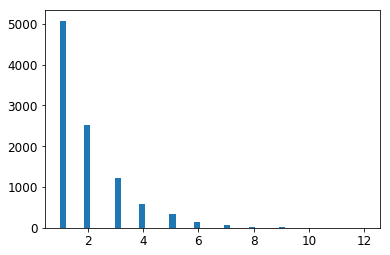

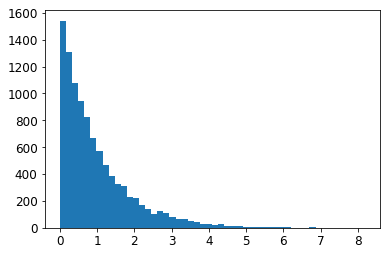

In [137]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Rozwiązania ćwiczeń

## 1.

Pytanie: Wypróbuj regresor maszyny wektorów nośnych (`sklearn.svm.SVR`) przy użyciu różnych hiperparametrów, takich jak `kernel="linear"` (oraz różnych wartości hiperparametru `C`) lub `kernel="rbf"` (oraz różnych wartości hiperparametrów `C` i `gamma`). Na razie nie przejmuj się tym, że nie wiesz, do czego te hiperparametry służą. Jak się spisuje najlepszy predyktor maszyny wektorów nośnych?

In [138]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 15.7min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 26.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]}, {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2)

Najlepszy model uzyskuje następujący wynik (wyliczony za pomocą pięciokrotnego sprawdzianu krzyżowego): 

In [109]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.903139641669

Jest to znacznie gorszy rezultat od uzyskanego za pomocą klasy `RandomForestRegressor`. Sprawdźmy, jakie najlepsze hiperparametry zostały znalezione:

In [110]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

Jądro liniowe wydaje się być lepsze od jądra RBF. Zwróć uwagę, że wartość parametru `C` stanowi maksymalną przetestowaną wartość. W takiej sytuacji zdecydowanie należy uruchomić ponownie przeszukiwanie siatki z większymi wartościami tego hiperparametru (usuwając jednocześnie mniejsze wartości), ponieważ prawdopodobnie któraś z nich będzie jeszcze lepiej dostosowana do modelu.

## 2.

Pytanie: Spróbuj zastąpić klasę `GridSearchCV` klasą `RandomizedSearchCV`.

In [141]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# na stronie https://docs.scipy.org/doc/scipy-0.19.0/reference/stats.html
# znajdziesz dokumentację funkcji `expon()` i `reciprocal()`, a także innych funkcji rozkładu prawdopodobieństwa.

# Uwaga: parametr gamma jest ignorowany, gdy korzystamy z jądra "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 20.0min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 32.1min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F4B6987438>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F4B76136A0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2)

Najlepszy model uzyskuje następujący wynik (obliczony za pomocą pięciokrotnego sprawdzianu krzyżowego):

In [142]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.990537044083

Teraz uzyskaliśmy rezultat o wiele bardziej zbliżony do wydajności klasy `RandomForestRegressor` (ciągle mu jednak trochę brakuje). Przyjrzyjmy się znalezionym hiperparametrom:

In [143]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

Tym razem udało się znaleźć dobry zestaw hiperparametrów dla jądra RBF. Przeszukiwanie losowe zazwyczaj jest w stanie wyszukiwać w tym samym czasie lepsze hiperparametry od przeszukiwania siatki.

Sprawdźmy wykorzystany przez rozkład wykładniczy, wykorzystujący parametr `scale=1.0`. Zwróć uwagę, że niektóre próbki są znacznie większe lub mniejsze od wartości 1.0, ale gdy sprawdzimy logarytm tego rozkładu, zauważymy, że większość wartości mieści się głównie w przedziale od exp(-2) do exp(+2), czyli od mniej więcej 0.1 do 7.4.

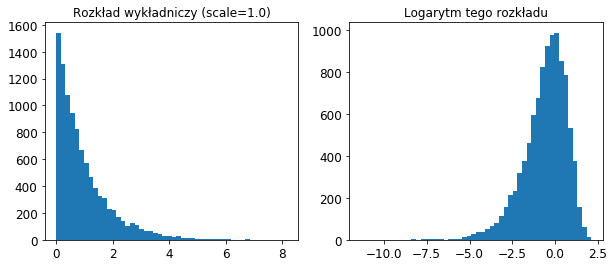

In [144]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Rozkład wykładniczy (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Logarytm tego rozkładu")
plt.hist(np.log(samples), bins=50)
plt.show()

Rozkład użyty dla hiperparametru `C` wygląda całkiem inaczej: skala próbek została wyznaczona z rozkładu jednorodnego o określonym zakresie, co stanowi powód, że wykres widoczny po prawej (reprezentujący logarytm rozkładu) jest mniej więcej jednolity. Rozkład ten przydaje się, gdy nie mamy pojęcia, jaka jest docelowa skala:

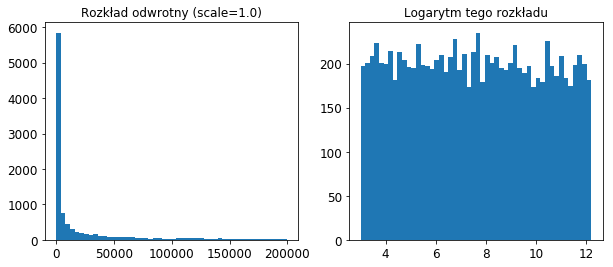

In [145]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Rozkład odwrotny (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Logarytm tego rozkładu")
plt.hist(np.log(samples), bins=50)
plt.show()

Rozkład odwrotny przydaje się wtedy, gdy nie wiemy, w jakiej skali powinien znajdować się dany hiperparametr (rzeczywiście, na prawym wykresie widzimy, że wszystkie skale mają mniej więcej takie samo prawdopodobobieństwo w określonym zakresie), natomiast rozkład wykładniczy nadaje się w sytuacjach, gdy w przybliżeniu znamy skalę hiperparametru.

## 3.

Pytanie: 3.	Spróbuj dodać w potoku przygotowawczym funkcję przekształcającą w taki sposób, aby były dobierane wyłącznie najistotniejsze atrybuty.

In [147]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Uwaga: Omawiany selektor cech zakłada, że już w jakiś sposób obliczyliśmy istotności cech (np. za pomocą klasy `RandomForestRegressor`). Być może kusi Cię, aby obliczyć je bezpośrednio w metodzie fit() klasy `TopFeatureSelector`, ale rozwiązanie to prawdopodobnie spowolniłoby proces przeszukiwania siatki/losowego, ponieważ istotności cech muszą zostać wyliczone dla każdej kombinacji hiperparametrów (chyba że zaimplementujesz jakąś formę pamięci podręcznej).

Zdefiniujmy liczbę najlepszych cech, które chcemy przechować:

In [149]:
k = 5

Przyjrzyjmy się teraz indeksom k najlepszych cech:

In [150]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12], dtype=int64)

In [151]:
np.array(attributes)[top_k_feature_indices]

array(['Dł. geograficzna', 'Szer. geograficzna', 'Mediana dochodów',
       'Populacja_na_rodzinę', 'INLAND'], 
      dtype='<U22')

Upewnijmy się, że mamy rzeczywiście do czynienia z k najlepszymi cechami:

In [152]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.36615898061813418, 'Mediana dochodów'),
 (0.16478099356159051, 'INLAND'),
 (0.10879295677551573, 'Populacja_na_rodzinę'),
 (0.073344235516012421, 'Dł. geograficzna'),
 (0.062909070482620302, 'Szer. geograficzna')]

Wygląda nieźle... Stwórzmy teraz nowy potok, w którym połączymy wcześniej zdefiniowany potok przygotowawczy z doborem k najlepszych cech:

In [153]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [154]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Przyjrzyjmy się cechom trzech pierwszych próbek:

In [155]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Upewnijmy się, że mamy do czynienia z k najlepszymi cechami: 

In [156]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Wszystko śmiga!  :)

## 4.

Pytanie: 4.	Spróbuj stworzyć pojedynczy potok przeprowadzający pełne przygotowywanie danych i generujący ostateczne prognozy.

In [157]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [158]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(steps=[('selector', DataFrameSelector(attribute_names=['Dł. geograficzna', 'Szer. geograficzna', 'Mediana wieku mieszkań', 'Całk. liczba pokoi', 'Całk. liczba sypialni', 'Populacja', 'Rodziny', 'Mediana ... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

Wypróbujmy pełen potok na kilku próbkach:

In [159]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Prognozy:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Etykiety:\t\t", list(some_labels))

Prognozy:	 [ 203214.28978849  371846.88152572  173295.65441612   47328.3970888 ]
Etykiety:		 [286600.0, 340600.0, 196900.0, 46300.0]


Wygląda na to, że pełen potok działa prawidłowo. Prognozy, oczywiście, nie są jakieś wybitne: byłyby lepsze, gdybyśmy użyli najlepszego znalezionego wcześniej regresora `RandomForestRegressor` zamiast `SVR`.

## 5.

Pytanie: 1.	Sprawdź automatycznie niektóre funkcje przygotowawcze za pomocą klasy `GridSearchCV`.

In [128]:
param_grid = [
        {'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': list(range(1, len(feature_importances) + 1))}
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] preparation__num_pipeline__imputer__strategy=mean, feature_selection__k=3 
[CV] preparation__num_pipeline__imputer__strategy=mean, feature_selection__k=3 
[CV] preparation__num_pipeline__imputer__strategy=mean, feature_selection__k=3 
[CV] preparation__num_pipeline__imputer__strategy=mean, feature_selection__k=3 
[CV]  preparation__num_pipeline__imputer__strategy=mean, feature_selection__k=3, total=   9.0s
[CV] preparation__num_pipeline__imputer__strategy=mean, feature_selection__k=3 
[CV]  preparation__num_pipeline__imputer__strategy=mean, feature_selection__k=3, total=   9.0s
[CV] preparation__num_pipeline__imputer__strategy=median, feature_selection__k=3 
[CV]  preparation__num_pipeline__imputer__strategy=mean, feature_selection__k=3, total=   9.0s
[CV] preparation__num_pipeline__imputer__strategy=median, feature_selection__k=3 
[CV]  preparation__num_pipeline__imputer__strategy=mean, feature_selection__k=3, total=   

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.9min


[CV]  preparation__num_pipeline__imputer__strategy=mean, feature_selection__k=5, total=  10.0s
[CV] preparation__num_pipeline__imputer__strategy=median, feature_selection__k=5 
[CV]  preparation__num_pipeline__imputer__strategy=mean, feature_selection__k=5, total=   9.7s
[CV] preparation__num_pipeline__imputer__strategy=median, feature_selection__k=5 
[CV]  preparation__num_pipeline__imputer__strategy=median, feature_selection__k=5, total=  10.0s
[CV] preparation__num_pipeline__imputer__strategy=median, feature_selection__k=5 
[CV]  preparation__num_pipeline__imputer__strategy=median, feature_selection__k=5, total=   9.9s
[CV] preparation__num_pipeline__imputer__strategy=most_frequent, feature_selection__k=5 
[CV]  preparation__num_pipeline__imputer__strategy=median, feature_selection__k=5, total=   9.8s
[CV] preparation__num_pipeline__imputer__strategy=most_frequent, feature_selection__k=5 
[CV]  preparation__num_pipeline__imputer__strategy=median, feature_selection__k=5, total=   9.9

[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  4.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feature_selection__k': [3, 4, 5, 6, 7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2)

In [129]:
grid_search_prep.best_params_

{'feature_selection__k': 7,
 'preparation__num_pipeline__imputer__strategy': 'median'}

Najlepszą strategią klasy imputer jest most_frequent i najwidoczniej niemal wszystkie cechy okazują się przydatne (15 z 16). Ostatnia cecha (ISLAND) prawdopodobnie wprowadza jedynie dodatkowy szum.

Gratulacje! Wiesz już całkiem dużo na temat uczenia maszynowego. :) You already know quite a lot about Machine Learning. :)